# Towards re-training Voxelnet for new classes

The aim of this notebook is to tease apart the pieces of code in the Voxelnet pipeline. The eventual hope is to seperate out the model training and prediction steps into seperate pieces of code that can be used to train similiar pieces of data. 

# Input Data

## Labels

Labels designate the class and coordinates of the object. Not yet clear the order of the vertices of a 3d box. Let's look at an example.

In [51]:
import pandas
pandas.read_table('/ufrc/ewhite/b.weinstein/voxelnet_split/training/label_2/000003.txt',header=None,sep=" ")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Car,0.0,0,1.55,614.24,181.78,727.31,284.77,1.57,1.73,4.15,1.0,1.75,13.22,1.62
1,DontCare,-1.0,-1,-10.00,5.00,229.89,214.12,367.61,-1.00,-1.00,-1.00,-1000.0,-1000.00,-1000.00,-10.00
2,DontCare,-1.0,-1,-10.00,522.25,202.35,547.77,219.71,-1.00,-1.00,-1.00,-1000.0,-1000.00,-1000.00,-10.00


# Lidar Cloud

The lidar cloud is saved in binary format and read into voxelnet 

```
raw_lidar = np.fromfile(self.f_lidar[load_index], dtype=np.float32).reshape((-1, 4))
```

In [15]:
import numpy as np
%time pc=np.fromfile("/ufrc/ewhite/b.weinstein/voxelnet_split/training/velodyne/000003.bin",dtype=np.float32)

CPU times: user 435 µs, sys: 440 µs, total: 875 µs
Wall time: 1.29 ms


In [16]:
pc.shape

(452440,)

Reshape into a 4xN matrix from the read me "Here, data contains 4*num values, where the first 3 values correspond to
x,y and z, and the last value is the reflectance information."

In [18]:
pc.reshape(-1,4)

array([[ 68.1269989 ,   0.145     ,   2.51300001,   0.        ],
       [ 68.73999786,   0.36199999,   2.53399992,   0.        ],
       [ 69.38999939,   0.58399999,   2.55599999,   0.        ],
       ..., 
       [  3.74000001,  -1.40799999,  -1.74800003,   0.44999999],
       [  3.74000001,  -1.39400005,  -1.745     ,   0.        ],
       [  3.76300001,  -1.38999999,  -1.75399995,   0.        ]], dtype=float32)

---

Okay that's what we are working with, how does it get fed into the model?

The essential [function](https://github.com/bw4sz/voxelnet/blob/44e429b92246d2f253fa9cd1af13cb420293abfc/train.py#L101) in train.py appears to be "iterate_data" from kitti_loader

In [1]:
from utils.kitti_loader import iterate_data

In [2]:
data_dir="/ufrc/ewhite/b.weinstein/voxelnet_split/training"

Let's see what this method yields

In [6]:
grab_data=iterate_data(data_dir)

In [9]:
next(grab_data)

(array(['000000'], dtype='<U6'),
 array([['Pedestrian 0.00 0 -0.20 712.40 143.00 810.73 307.92 1.89 0.48 1.20 1.84 1.47 8.41 0.01\n']],
       dtype='<U87'),
 array([[[[ 3.8050001e+00, -7.0460000e+00, -2.7539999e+00, ...,
           -9.0000629e-03, -9.9997520e-03, -1.4998913e-03],
          [ 3.8230000e+00, -7.0260000e+00, -2.7509999e+00, ...,
            8.9998245e-03,  1.0000229e-02,  1.5001297e-03],
          [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           -3.8140001e+00,  7.0360003e+00,  2.7525001e+00],
          ...,
          [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           -3.8140001e+00,  7.0360003e+00,  2.7525001e+00],
          [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           -3.8140001e+00,  7.0360003e+00,  2.7525001e+00],
          [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           -3.8140001e+00,  7.0360003e+00,  2.7525001e+00]],
 
         [[ 4.1199999e+00, -7.0539999e+00, -2.6610000e+00, ...,
           -3.70

In [10]:
sample=next(grab_data)

So what's in this sample? Looking at the [source](https://github.com/bw4sz/voxelnet/blob/44e429b92246d2f253fa9cd1af13cb420293abfc/utils/kitti_loader.py#L146), we can get a pretty good guess.

# 0: "Tag" - this is the identifier of the data that acts an index across lidar, label and image sets. 

In the Kitti dataset, these are 6 digit numbers, starting at 000000.

In [13]:
sample[0]

array(['000003'], dtype='<U6')

# 1: "label" this is class label. 

The Don't Care label was introduced in preprocessing for this particular dataset.

In [15]:
sample[1]

array([['Car 0.00 0 1.55 614.24 181.78 727.31 284.77 1.57 1.73 4.15 1.00 1.75 13.22 1.62\n',
        'DontCare -1 -1 -10 5.00 229.89 214.12 367.61 -1 -1 -1 -1000 -1000 -1000 -10\n',
        'DontCare -1 -1 -10 522.25 202.35 547.77 219.71 -1 -1 -1 -1000 -1000 -1000 -10\n']],
      dtype='<U80')

# 2: "vox_feature"
no idea yet how could features already been extracted, this is the raw data?

In [16]:
sample[2]

array([[[[ 6.5392998e+01, -1.0480000e+00, -2.7049999e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          -6.5392998e+01,  1.0480000e+00,  2.7049999e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          -6.5392998e+01,  1.0480000e+00,  2.7049999e+00],
         ...,
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          -6.5392998e+01,  1.0480000e+00,  2.7049999e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          -6.5392998e+01,  1.0480000e+00,  2.7049999e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          -6.5392998e+01,  1.0480000e+00,  2.7049999e+00]],

        [[ 6.5897003e+01, -8.4899998e-01, -2.7279999e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          -6.5897003e+01,  8.4899998e-01,  2.7279999e+00],
        

# 3: Vox Number. 

The index of the voxel?

In [19]:
sample[3]

array([[1, 1, 1, ..., 4, 2, 1]])

# 4: vox_coordinate.
The position of the voxel

In [22]:
sample[4]

array([[[  0,   0, 194, 326],
        [  0,   0, 195, 329],
        [  0,   0, 196, 332],
        ...,
        [  0,   9, 257,  28],
        [  0,   9, 257,  29],
        [  0,   9, 258,  27]]])

# 5: The rgb image
let's see if we can load it 

In [36]:
img=sample[5][0,:,:,:]

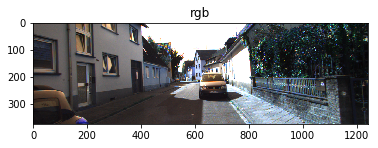

In [38]:
from matplotlib import pyplot as plt
import cv2

plt.imshow(img)
plt.title('rgb')
plt.show()

# 6: raw lidar

The lidar cloud

In [40]:
sample[6]

array([[[68.127,  0.145,  2.513,  0.   ],
        [68.74 ,  0.362,  2.534,  0.   ],
        [69.39 ,  0.584,  2.556,  0.   ],
        ...,
        [ 3.74 , -1.408, -1.748,  0.45 ],
        [ 3.74 , -1.394, -1.745,  0.   ],
        [ 3.763, -1.39 , -1.754,  0.   ]]], dtype=float32)

In [41]:
sample[6].shape

(1, 113110, 4)